In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.models import load_model
import os
from keras.initializers import glorot_uniform
from keras.initializers import glorot_uniform
from keras.utils.generic_utils import get_custom_objects
import _pickle as pickle
from model import model_predict
from data_prepare import categorical_factory
from performance import performance_factory

Using TensorFlow backend.


In [3]:
function = "params_select"
# # sz50
# uid1 = 'test_model01'
# uid2 = 'fc7fbff0-f5e9-11e7-b733-525400f48026'

# hs300
uid1 = 'test_hs300_model03'
# uid2 = 'e0a5c034-f690-11e7-b733-525400f48026'
uid2 = '6dba7718-f767-11e7-b733-525400f48026'

# # zz500
# uid1 = 'test_zz500_model01'
# uid2 = 'c5d6287c-f68e-11e7-b733-525400f48026'

namespace = function + '_' + uid1
log_dir = os.path.join('./', namespace)
sub_log_dir = os.path.join(log_dir, uid2)


models = {}
measure = 'acc'
measure_values = [0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95]
for value in measure_values:
    print(value)
    model_file = os.path.join(sub_log_dir, '{}_{}.h5'.format(measure, value))
    if os.path.exists(model_file):
        print('loading file {}...'.format(model_file))
        models[value] = load_model(model_file)

0.35
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.35.h5...
0.4
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.4.h5...
0.45
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.45.h5...
0.5
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.5.h5...
0.55
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.55.h5...
0.6
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.6.h5...
0.65
loading file ./params_select_test_hs300_model03/6dba7718-f767-11e7-b733-525400f48026/acc_0.65.h5...
0.7
0.75
0.8
0.9
0.95


In [4]:
to_be_predict_set = pickle.load(open(os.path.join(sub_log_dir, 'to_be_predict_set.pkl'), 'rb'))

In [5]:
class_list = [i for i in range(3)]
nb_class = len(class_list)
_, reverse_categorical = categorical_factory(class_list)
performance_func = performance_factory(reverse_categorical, 
                                       performance_types=['Y0', 'Y', 'returns', 
                                                          'cum_returns', 'annual_return','sharpe_ratio'], 
                                       mid_type=(nb_class-1) / 2.0, epsilon=0.3)

In [6]:
performances = {}
for value in measure_values:
    if value in models:
        model = models[value]
        for tag in to_be_predict_set:
            performances['{}_{}'.format(value, tag)] = model_predict(model, to_be_predict_set[tag][0], to_be_predict_set[tag][1], 
                                              performance_func)
            scores = model.evaluate(to_be_predict_set[tag][1], to_be_predict_set[tag][2], verbose=1)
            performances['{}_{}'.format(value, tag)]['loss'] = scores[0]
            performances['{}_{}'.format(value, tag)]['metrics'] = scores[1]

59/59 [==============================] - 0s 2ms/step


In [7]:
performances['0.5_validate'].keys()

dict_keys(['Y0', 'sharpe_ratio', 'annual_return', 'Y', 'metrics', 'loss', 'cum_returns', 'returns'])

In [8]:
df_perf = pd.DataFrame(columns=['tag', 'sharpe_ratio', 'annual_return'])
test_type = 'validate'
for value in measure_values:
    tag = '{}_{}'.format(value, test_type)
    if tag in performances:
        df_perf.loc[len(df_perf)] = [tag, performances[tag]['sharpe_ratio'], performances[tag]['annual_return']]
        

In [9]:
df_perf.sort_values('sharpe_ratio', ascending=False)

,tag,sharpe_ratio,annual_return
5,0.6_validate,0.089818,-0.001994
1,0.4_validate,0.062980,-0.014199
4,0.55_validate,0.041512,-0.020009
0,0.35_validate,-0.000083,-0.027458
3,0.5_validate,-0.073344,-0.053394
2,0.45_validate,-0.154370,-0.055602
6,0.65_validate,-0.278420,-0.086950


In [16]:
test_type = 'test'
value = 0.6
weight = 0.7

tag = '{}_{}'.format(value, test_type)
argmax = performances[tag]['Y0'].map(np.argmax) 
max_value = performances[tag]['Y0'].map(np.max)
signal = pd.concat([argmax, max_value], axis=1)
signal.columns = ['signal', 'weight']
pct_chg = to_be_predict_set[test_type][0]['pct_chg']

cal_returns = pd.concat([signal.shift(1), pct_chg], axis=1)
cal_returns['returns'] = np.nan
cond = (cal_returns['weight'] > weight) & (cal_returns['signal'] > 0)
returns = cal_returns['signal'] * cal_returns['pct_chg']
returns[pct_chg.shift(1) > 0.098] = np.nan
cal_returns.loc[cond, 'returns'] =  returns.loc[cond]

/home/ubuntu/.pyenv/versions/3.5.4/lib/python3.5/site-packages/pandas/core/frame.py:4910: RuntimeWarning: Mean of empty slice
  labels=labels)


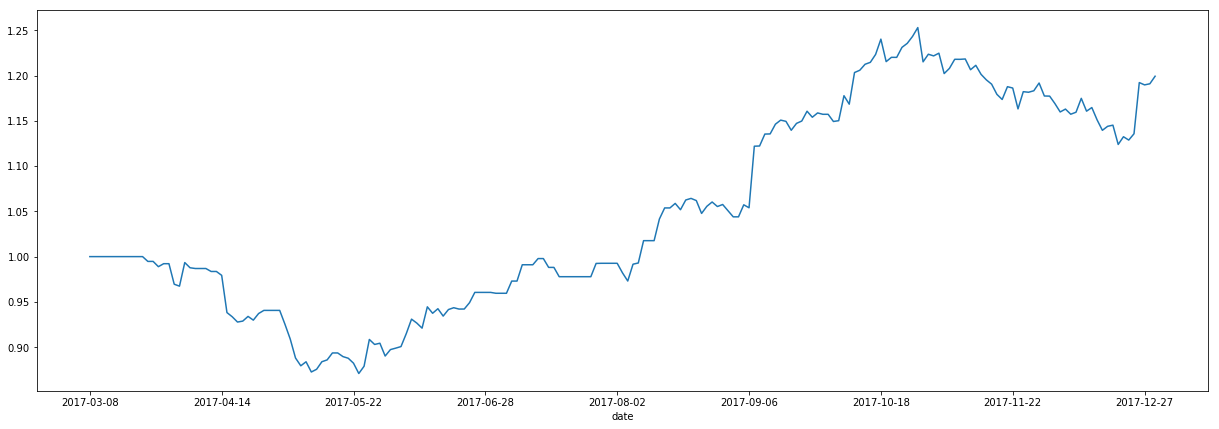

In [17]:
returns = cal_returns['returns'].unstack(level=0).apply(np.nanmean,axis=1).fillna(0)
(returns + 1).cumprod().plot(figsize=(21, 7))

In [12]:
import empyrical

In [13]:
empyrical.sharpe_ratio(returns)

nan